# 2. Статистика дефолтов, рейтинги и их свойства

Для оценки вероятностей дефолтов требуется дополнительный инструментарий - показатель ранжирования по кредитному риску - рейтинги, скоринг, рыночные меры кредитного риска (например, спрэд облигаций).

В этом курсе мы рассматриваем рейтинги - набор категорий или ступеней кредитного качества, по которым распределяются все заемщики.  

Обозначать рейтинговую категорию будем $Ri$. Если $i < j$, то $Ri \succ Rj$, т.е. кредитный риск в категории $Ri$ **ниже**, чем в категрии $Rj$.

**Качественный рейтинг**:
 - монотонно ранжирует по кредитному качеству,
 - категории как можно сильнее различаются по уровню кредитного качества (что выражается в стремительном росте PD). 

Рассматриваем риск дефолта на горизонте $h$. 

| Rating | Rated at t (N) | Defaulted by t+h (D)  | Survived by t+h (S)|
|:-------|:-------|:-------|:-------|
| R1| 10 | 0 | 10 |
|R2 | 20 | 1 | 19| 
|R3 | 30 | 3 | 27| 
....

<font color='red'>**Замечание!!!**</font> 

В $N$ входят только те заемщики, для которых:

* горизонт риска не меньше $h$,
* однозначно можно определить допустил или нет дефолт заемщик (т.е. достоверно можно отнести к столбцу $D$ и $S$ на выбранном горизонте.

Изменение $h$ может изменять количество наблюдений в $N$: например, рост горизонта приводит к тому, что количество наблюдений в N уменьшается, а дефолтеров растет. Т.е. структура выборки меняется.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

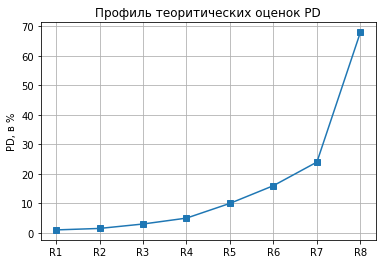

,N,D,S
R1,10,0,10
R2,20,0,20
R3,30,0,30
R4,40,1,39
R5,50,4,46
R6,40,4,36
R7,30,8,22
R8,20,12,8


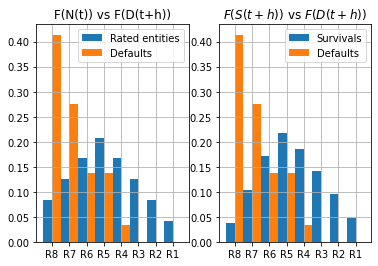

In [ ]:
k = 8 # количество рейтинговых категорий, исключая дефолт

# Зададим рейтинговую шкалу
grades = ['R{}'.format(i+1) for i in range(k)] 

# Пусть каждой рейтинговой категории соответствует своя вероятность дефолта
# Профиль PD монотонно возрастает
pds = np.array([.01, 0.015, .03, .05, .10, .16, .24, .68 ])
plt.plot(grades, 100*pds, '-s')
plt.title('Профиль теоритических оценок PD')
plt.ylabel('PD, в %')
plt.grid(), plt.show()

# Рассмотрим распределение заемщиков по рейтинговым категориям
N  = np.array([10, 20, 30, 40, 50, 40, 30, 20]) 

# Сгенерируем дефолты
np.random.seed(65)
D = np.random.binomial(N, pds)
S = N - D

data = pd.DataFrame({
                     'N': N,
                     'D': D,
                     'S': N - D,
                          }, index = grades)
display(data)

# Вспомогательный код для подписей к осям
x_1 = [i-0.25 for i in range(8)]
x_2 = [i+0.25 for i in range(8)]

# Распределение исходных наблюдения против распределения наблюдений за дефолтерам
plt.subplot(1, 2, 1)
plt.bar(x_1, (N/N.sum())[::-1],width=0.5, label = 'Rated entities')
plt.bar(x_2, (D/D.sum())[::-1], width=0.5, label = 'Defaults')
plt.title(r'F(N(t)) vs F(D(t+h))')
plt.xticks(range(8), grades[-1::-1]), plt.grid(), plt.legend()
# plt.show()

# Распределение добросовестных заемщиков против распределения дефолтеров
plt.subplot(1, 2, 2)
plt.bar(x_1, (S/S.sum())[::-1],width=0.5, label = 'Survivals')
plt.bar(x_2, (D/D.sum())[::-1],width=0.5, label = 'Defaults')
plt.title(r'$F (S(t+h))$ vs $F( D(t+h))$')
plt.xticks(range(8), grades[-1::-1]), plt.grid(), plt.legend()
plt.show()


## Дискриминационная способность рейтингов

Графические инструменты:

- Cumulative Accuracy Profile (CAP)
- Receiver Operating Characteristic (ROC)

Количественные меры:

- Area Under Curve (AUC)
- Accuracy Ratio (AR or Gini coefficient)

In [ ]:
def cap_roc_data(data):
  '''
  data.N - количество заемщиков в каждой категории на начало периода в порядке улучшения рейтинга
  data.D - количество дефолтов в каждой категории на конец периода в порядке улучшения рейтинга
  data.S - количество "выживших" в каждой категории на конец периода в порядке улучшения рейтинга

  ppr - Population Positive Rate (доля рейтингов ниже определенного уровня или значение функции распределения заемщиков относительно рейтинговой шкалы F(N))
  tpr - True Positive Rate (доля дефолтеров, попавших в рейтинги ниже определенного уровня, или значение функции распределения дефолтеров относительно рейтинговой шкалы F(D))
  tpr - False Positive Rate (доля "выживших", попавших в рейтинги ниже определенного уровня, или значение функции распределения выживших относительно рейтинговой шкалы F(S))
  '''
  data = data[::-1]
  N, D, S = np.insert(data.N.values, 0, 0), np.insert(data.D.values, 0, 0), np.insert(data.S.values, 0, 0)
  ppr, tpr, fpr = N.cumsum()/N.sum(), D.cumsum()/D.sum(), S.cumsum()/S.sum() # F(N), F(D), F(S)
  return ppr, tpr, fpr 

In [ ]:
# Обработаем данные для построения 
display(data)
emp_ppr, emp_tpr, emp_fpr = cap_roc_data(data)

data_thr = pd.DataFrame({
    'N': data.N.values,
    'D': data.N.values*pds,
    'S': data.N.values*(1 - pds)
})
thr_ppr, thr_tpr, thr_fpr = cap_roc_data(data_thr)

,N,D,S
R1,10,0,10
R2,20,0,20
R3,30,0,30
R4,40,1,39
R5,50,4,46
R6,40,4,36
R7,30,8,22
R8,20,12,8


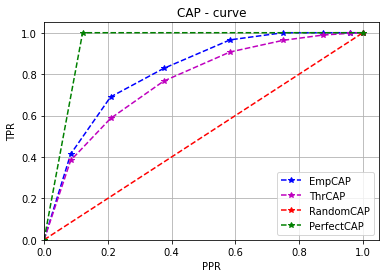

In [ ]:
# Построим CAP- кривую (эмпирическую и теоретическию):
plt.title('CAP - curve')
plt.grid()
plt.plot(emp_ppr, emp_tpr, '--*b', label = 'EmpCAP')
plt.plot(thr_ppr, thr_tpr, '--*m', label = 'ThrCAP')
plt.plot([0, 1], [0, 1], '--*r', label = 'RandomCAP')
plt.plot([0, data.D.sum()/data.N.sum() ,1], [0, 1, 1], '--*g',label = 'PerfectCAP')
plt.xlim([0,1.05]), plt.xlabel('PPR'), plt.ylabel('TPR')
plt.ylim([0,1.05])
plt.legend()

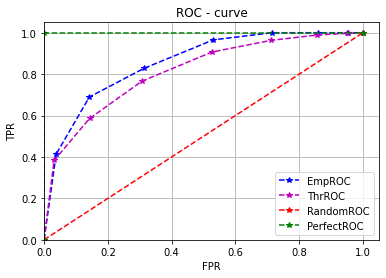

In [ ]:
# Построим ROC- кривую (эмпирическую и теоретическию):
plt.title('ROC - curve')
plt.grid()
plt.plot(emp_fpr, emp_tpr, '--*b', label = 'EmpROC')
plt.plot(thr_fpr, thr_tpr, '--*m', label = 'ThrROC')
plt.plot([0, 1], [0, 1], '--*r', label = 'RandomROC')
plt.plot([0, 0 ,1], [0, 1, 1], '--*g',label = 'PerfectROC')
plt.xlim([0,1.05]), plt.xlabel('FPR'), plt.ylabel('TPR')
plt.ylim([0,1.05])
plt.legend()

Разделяющую способность можно рейтинговой модели можно оценить с помощью показателей AUC (area under curve) и AR (accuracy ratio, Gini).

Для CAP-кривой:

$$AUC_{CAP} = 0.5\sum\limits_{i=0,..,k-1}(TPR_{i+1} + TPR_i)(PPR_{i+1} -PPR_i)$$
$$DR = \frac{\sum_i{D_i}}{\sum_i{N_i}}$$
$$ AR_{CAP} = \frac{AUC_{CAP} - 0.5}{AUC_{PerfectCAP} -0.5} =  \frac{AUC - 0.5}{0.5(1- DR)} = \frac{2AUC_{CAP} - 1}{1- DR}$$

Для ROC-кривой:

$$AUC_{ROC}= 0.5\sum\limits_{i=0,..,k-1}(TPR_{i+1} + TPR_i)(FPR_{i+1} -FPR_i)$$
$$ AR_{ROC} = \frac{AUC_{ROC} - 0.5}{AUC_{PerfectROC} -0.5} = 2AUC_{ROC} - 1$$

In [ ]:
# Вычислим AUC и AR (Gini) по CAP
emp_dr, thr_dr  =  D.sum()/N.sum(), (N*pds).sum()/N.sum() 

emp_auc, thr_auc = 0.5 * (emp_tpr[1:] + emp_tpr[:-1])@(emp_ppr[1:] - emp_ppr[:-1]), 0.5 * (thr_tpr[1:] + thr_tpr[:-1])@(thr_ppr[1:] - thr_ppr[:-1])
emp_ar, thr_ar = (2*emp_auc - 1)/(1 - D.sum()/N.sum()), (2*thr_auc - 1)/(1 - (N*pds).sum()/N.sum())

print( 'Эмпирический DR = {:.2%},  эмпирический AUC = {:.3f},  эмпирический AR = {:.2%}\n'.format(emp_dr, emp_auc, emp_ar))
print('Теоретический DR = {:.2%}, теоретический AUC = {:.3f}, теоретический AR = {:.2%}'.format(thr_dr, thr_auc, thr_ar))


Эмпирический DR = 12.08%,  эмпирический AUC = 0.813,  эмпирический AR = 71.25%

Теоретический DR = 14.79%, теоретический AUC = 0.766, теоретический AR = 62.37%


In [ ]:
# Вычислим AUC и AR (Gini) по ROC
emp_auc, thr_auc = 0.5 * (emp_tpr[1:] + emp_tpr[:-1])@(emp_fpr[1:] - emp_fpr[:-1]), 0.5 * (thr_tpr[1:] + thr_tpr[:-1])@(thr_fpr[1:] - thr_fpr[:-1])
emp_ar, thr_ar = (2*emp_auc - 1), (2*thr_auc - 1)

print( 'Эмпирический AUC = {:.3f},  эмпирический AR = {:.2%}\n'.format(emp_auc, emp_ar))
print('Теоретический AUC = {:.3f}, теоретический AR = {:.2%}'.format(thr_auc, thr_ar))


Эмпирический AUC = 0.856,  эмпирический AR = 71.25%

Теоретический AUC = 0.812, теоретический AR = 62.37%
